**CRIB SHEET RULES OF THE ROAD:**

This crib sheet is provided to support access, utilization, and plotting of UCalgary optical datasets. It is intended as a base set of code that a user may edit and manipulate to serve their own needs.  Crib sheets contains UCalgary verified and validated procedures for plotting and manipulating UCalgary ASI data for common use cases.  Use of this crib sheet does not require acknowledgment, it is freely distributed for scientific use. Please also remember to perform due diligence on all data use.  We recommend comparison with verified data products on [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca) to ensure that any user output does not contradict operational summary plots.  Data use must be acknowledged according to the information available for each data set - please see [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca).  If you encounter any issues with the data or the crib sheet, please contact the UCalgary team for support (Emma Spanswick, elspansw@ucalgary.ca). Copyright © University of Calgary.

---
# **Georeferencing Single-Channel ASI Data**
---

### **Datasets**
All datasets can be found at https://data.phys.ucalgary.ca. This crib sheet currently pertains to the following datasets:
- THEMIS ASI
- REGO
- TREx NIR
- *TREx Blueline - Skymaps Coming Soon*

</br>

### **Crib Sheet Summary**
With the code in this crib sheet, one can create mosaics from single-channel images in data numbers, scaled data numbers, or calibrated luminosity (i.e., Rayleighs).

Multi-channel imager mosaics and mosaics with multiple network (camera) types are covered in other crib sheets.

Note: this crib sheet utilizes geospatial calbration of ASIs, information on the UCalgary geospatial calibration files can be found here, https://data.phys.ucalgary.ca/sort_by_project/other/documentation/skymap_file_description.pdf

</br>

---

</br>


## **Install dependencies**

Here we'll install [PyAuroraX](https://github.com/aurorax-space/pyaurorax), and import it.

Some helpful links:
  - [PyAuroraX documentation](https://docs.aurorax.space/code/overview)
  - [PyAuroraX API Reference](https://docs.aurorax.space/code/pyaurorax_api_reference/pyaurorax)
  - [Jupyter notebook examples](https://github.com/aurorax-space/pyaurorax/tree/main/examples/notebooks)


In [ ]:
!pip install -i https://test.pypi.org/pypi/ --extra-index-url https://pypi.org/simple pyaurorax==1.0.0-rc3

Looking in indexes: https://test.pypi.org/pypi/, https://pypi.org/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.3/193.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 7.1 MB/s eta 0:00:00
  Created wheel for aacgmv2: filename=aacgmv2-2.6.3-cp310-cp310-linux_x86_64.whl size=1679867 sha256=dc7cde6bb7840996070c62c216907baba67671f69b6d6193b47cf8f1e11e9ecc
  Stored in directory: /root/.cache/pip/wheels/e9/d6/3f/10a359ebb903b2dbe5aa94f7024b5284059bb0daef65a7a0b4
Successfully built aacgmv2
  Attemptin

In [ ]:
import datetime
import pprint
import matplotlib.pyplot as plt
import cartopy
import pyaurorax
from tqdm.auto import tqdm

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

## **Downloading Data**

We need to download the data we're going to be using. PyAuroraX provides functions to handle this for you. You can learn more about how to use them by looking at the 'Data download` crib sheet, reading the PyAuroraX documentation, or the PyAuroraX API reference. Links are above.

If you prefer our other methods to download the data (basic HTTP, FTP, Rsync), that is also possible. You would download the data and skip to the data reading step of this crib sheet.

In [ ]:
# We can set the path of where we want to save data to. By default,
# PyAuroraX saved data to your home directory. Since we can be running
# this crib sheet on Google Colab, we're going to do a special case
# and set the path if running in Colab. We'll leave the default if
# running in a different environment.
import sys
if ("google.colab" in sys.modules):
    aurorax.download_output_root_path = "/content/ucalgary_data"
    aurorax.read_tar_temp_path = "/content/ucalgary_data/tar_temp_working"
print(aurorax)

PyAuroraX(download_output_root_path='/content/ucalgary_data', read_tar_temp_path='/content/ucalgary_data/tar_temp_working', api_base_url='https://api.aurorax.space', api_headers={'content-type': 'application/json', 'user-agent': 'python-pyaurorax/1.0.0-rc1'}, api_timeout=10, api_key='None', srs_obj=PyUCalgarySRS(...))


In [ ]:
# download an hour of REGO raw data from Gillam
dataset_name = "REGO_RAW"
start_dt = datetime.datetime(2023, 2, 24, 6, 0)
end_dt = datetime.datetime(2023, 2, 24, 6, 59)
site_uid = "gill"
r_rego_raw_1hr = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)

# download 1 minute of REGO data from all sites
dataset_name = "REGO_RAW"
start_dt = datetime.datetime(2023, 2, 24, 6, 40)
end_dt = datetime.datetime(2023, 2, 24, 6, 40)
r_rego_raw_allsites1 = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt)

# download another 1 minute of REGO data from all sites
dataset_name = "REGO_RAW"
start = "2023-02-24T06:15"
end = "2023-02-24T06:15"
start_dt = datetime.datetime(2023, 2, 24, 6, 15)
end_dt = datetime.datetime(2023, 2, 24, 6, 15)
r_rego_raw_allsites2 = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt)

# download REGO skymaps
r_rego_skymaps = {}
for site_uid in tqdm(["fsim", "gill", "luck", "rank"], desc="Downloading skymaps", unit="skymap"):
    r_rego_skymaps[site_uid] = aurorax.data.ucalgary.download_best_skymap("REGO_SKYMAP_IDLSAV", site_uid, timestamp=datetime.datetime(2023, 2, 24))

# download REGO calibration files
r_rego_cal_rayleighs = {}
r_rego_cal_flatfields = {}
for device_uid in tqdm(["656", "652", "651", "649"], desc="Downloading calibration files", unit="file"):
    r_rego_cal_rayleighs[device_uid] = aurorax.data.ucalgary.download_best_rayleighs_calibration(
      "REGO_CALIBRATION_RAYLEIGHS_IDLSAV", device_uid, timestamp=datetime.datetime(2023, 2, 24))
    r_rego_cal_flatfields[device_uid] = aurorax.data.ucalgary.download_best_flatfield_calibration(
      "REGO_CALIBRATION_FLATFIELD_IDLSAV", device_uid, timestamp=datetime.datetime(2023, 2, 24))

# download 1 minute of THEMIS ASI data from all sites
dataset_name = "THEMIS_ASI_RAW"
start_dt = datetime.datetime(2023, 2, 24, 6, 40)
end_dt = datetime.datetime(2023, 2, 24, 6, 40)
r_themis_raw_allsites = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt)

# download THEMIS skymaps
r_themis_skymaps = {}
for site_uid in tqdm(["talo", "inuv", "gill", "fsmi", "atha"], desc="Downloading skymaps", unit="skymap"):
    r_themis_skymaps[site_uid] = aurorax.data.ucalgary.download_best_skymap("THEMIS_ASI_SKYMAP_IDLSAV", site_uid, timestamp=datetime.datetime(2023, 2, 24))

## **Georeferencing Keograms**

Creating keograms is covered in the 'Loading, Calibrating, and Plotting Single Channel ASI Data' crib sheet, but it is often useful to be able to georeference a koegram's axes.

In [ ]:
# read in an hour of REGO data
data = aurorax.data.ucalgary.read(r_rego_raw_1hr.dataset, r_rego_raw_1hr.filenames, n_parallel=2)
data.pretty_print()

Data:
  data                  : array(dims=(512, 512, 1200), dtype=uint16)
  timestamp             : [1200 datetimes]
  metadata              : [1200 dictionaries]
  problematic_files     : []
  calibrated_data       : None
  dataset               : Dataset(name=REGO_RAW, short_description='REGO All Sky Imagers 3-sec raw da...)


For each camera, the UCalgary maintains a geospatial calibration dataset that maps pixel coordinates (detector X and Y) to local observer and geodetic coordinates (at altitudes of interest). We refer to this calibration as a 'skymap'. The skymaps may change due to the freeze-thaw cycle and changes in the building, or when the instrument is serviced. A skymap is valid from the date it is produced, until it is superseded by another file.

Be sure you choose the correct skymap for your data timeframe. You can view all skymaps by looking at the data tree for the imager you are using (see https://data.phys.ucalgary.ca/), or use the PyAuroraX `get_urls()` or `download()` functions. If you believe the geospatial calibration may be incorrect, please contact the UCalgary team.

For more on the skymap files, please see https://data.phys.ucalgary.ca/sort_by_project/other/documentation/skymap_file_description.pdf

In [ ]:
# read in the skymap for this site
#
# NOTE: we'll use the download object we saved up above, but you can alternatively
# specify the filename manually, or use glob to find it on your computer
skymap_file = r_rego_skymaps["gill"].filenames[0]
print(skymap_file)
print()

# read in the file
skymap_data = aurorax.data.ucalgary.read(r_rego_skymaps["gill"].dataset, skymap_file)
skymap_data.pretty_print()
print()
skymap_data.data[0].pretty_print()

/content/ucalgary_data/REGO_SKYMAP_IDLSAV/gill/gill_20230124/rego_skymap_gill_20230124-+_v01.sav

Data:
  data                  : [1 Skymap object]
  timestamp             : []
  metadata              : []
  problematic_files     : []
  calibrated_data       : None
  dataset               : Dataset(name=REGO_SKYMAP_IDLSAV, short_description='REGO All Sky Imagers sk...)

Skymap:
  filename               : /content/ucalgary_data/REGO_SKYMAP_IDLSAV/gill/gill_20230124/rego_skymap_gill_20230124-+_v01.sav
  full_azimuth           : array(dims=(512, 512), dtype=>f4)
  full_elevation         : array(dims=(512, 512), dtype=>f4)
  full_map_altitude      : array(dims=(3,), dtype=>f4)
  full_map_latitude      : array(dims=(3, 513, 513), dtype=>f4)
  full_map_longitude     : array(dims=(3, 513, 513), dtype=>f4)
  generation_info        : SkymapGenerationInfo(...)
  get_precalculated_altitudes: <bound method Skymap.get_precalculated_altitudes of Skymap(project_uid=rego, site_uid=gill, imager_uid=reg

In [ ]:
# scale the images
images_scaled = at.scale_intensity(data.data, min=400, max=1300)

# create a keogram
keogram = at.keogram.create(images_scaled, data.timestamp)

In [ ]:
# set the geographic coordinates
keogram.set_geographic_latitudes(skymap_data.data[0])

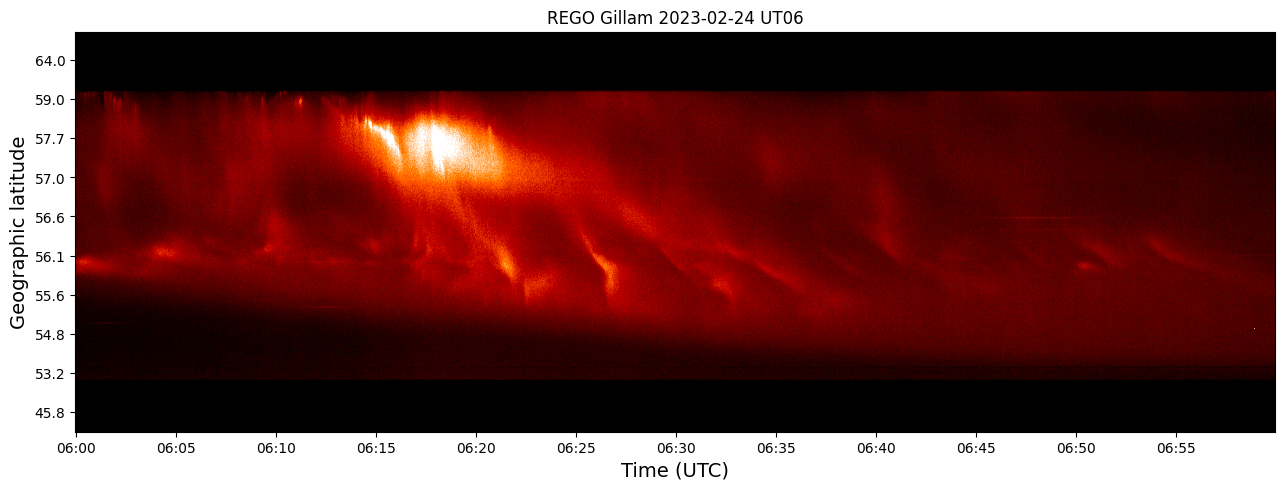

In [ ]:
# plot the data
keogram.plot(
    figsize=(12, 4),
    cmap="gist_heat",
    y_type="geo",
    aspect="auto",
    title="REGO Gillam %s" % (data.timestamp[0].strftime("%Y-%m-%d UT%H")),
)

## **Geomagnetic Coordinates**

Using the AACGM Python library, it is straightforward to convert the skymap coordinates to geomagnetic coordinates. We will show this below.

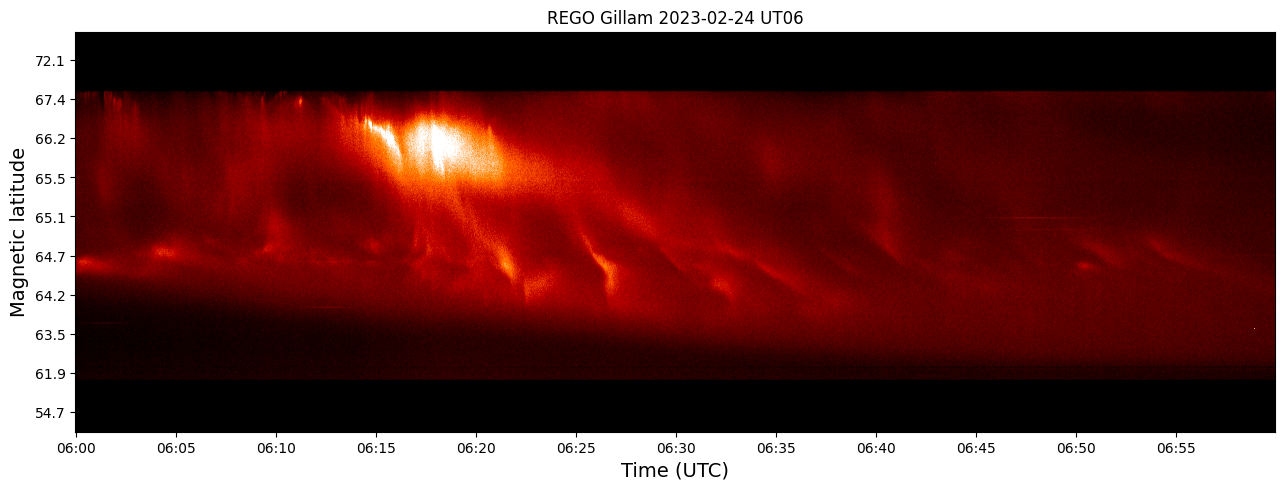

In [ ]:
# set the geomagnetic latitudes
keogram.set_magnetic_latitudes(skymap_data.data[0], data.timestamp[0])

# plot the data
keogram.plot(
    figsize=(12, 4),
    cmap="gist_heat",
    y_type="mag",
    aspect="auto",
    title="REGO Gillam %s" % (data.timestamp[0].strftime("%Y-%m-%d UT%H")),
)

## **Creating a Mosaic**

The process of making a mosaic involves properly accounting for the mapping of each pixel. Due to the fisheye optics, the pixels become increasingly large as you move away from zenith, to lower elevation angles.

  Our methodology for creating mosaics relies on two key points.


1.   we must accurately account for the changing (and unique) pixel areas and locations in geodetic coordinates, and
2.   when putting multiple imagers together, we want to use the information from the closest camera

Our methodology involves creating exact polygons for each pixel (this is why the skymap contains the pixel corners!), for each camera and filling those polygons with the correct (scaled, or calibrated) imager data. This methodology ensures accuracy of all pixels within the FoV.

The procedure for making a mosaic is best done in 1D vector space.  Below you will find functions that convert the skymaps and images to vectors, before plotting those vectors.

In [ ]:
# read the skymap data
#
# NOTE: the order of the sites here is very important, as that order MUST be the same
# for both the skymap and image data we pass into the mosaic prep routines.
dataset = r_themis_skymaps["atha"].dataset
skymap_file_list = [
    r_themis_skymaps["fsmi"].filenames[0],
    r_themis_skymaps["gill"].filenames[0],
    r_themis_skymaps["inuv"].filenames[0],
    r_themis_skymaps["atha"].filenames[0],
    r_themis_skymaps["talo"].filenames[0],
]
skymap_data = aurorax.data.ucalgary.read(dataset, skymap_file_list, n_parallel=2)
skymap_data.pretty_print()

Data:
  data                  : [5 Skymap objects]
  timestamp             : []
  metadata              : []
  problematic_files     : []
  calibrated_data       : None
  dataset               : Dataset(name=THEMIS_ASI_SKYMAP_IDLSAV, short_description='THEMIS All Sky Im...)


In [ ]:
# read in the image data
#
# to change it up a bit, we'll use glob to find the filenames
import pathlib
dataset = r_themis_raw_allsites.dataset
root_path = pathlib.Path(aurorax.download_output_root_path)

# NOTE: the order of the sites here is very important, as that order MUST be the same
# for both the skymap and image data we pass into the mosaic prep routines.
image_file_list = [
    list(root_path.glob("THEMIS_ASI_RAW/2023/02/24/fsmi*/ut06/20230224_0640*"))[0],
    list(root_path.glob("THEMIS_ASI_RAW/2023/02/24/gill*/ut06/20230224_0640*"))[0],
    list(root_path.glob("THEMIS_ASI_RAW/2023/02/24/inuv*/ut06/20230224_0640*"))[0],
    list(root_path.glob("THEMIS_ASI_RAW/2023/02/24/atha*/ut06/20230224_0640*"))[0],
    list(root_path.glob("THEMIS_ASI_RAW/2023/02/24/talo*/ut06/20230224_0640*"))[0],
]
pprint.pprint(image_file_list)
print()

image_data_list = []
for f in image_file_list:
    image_data_list.append(aurorax.data.ucalgary.read(dataset, f))
pprint.pprint(image_data_list)

[PosixPath('/content/ucalgary_data/THEMIS_ASI_RAW/2023/02/24/fsmi_themis10/ut06/20230224_0640_fsmi_themis10_full.pgm.gz'),
 PosixPath('/content/ucalgary_data/THEMIS_ASI_RAW/2023/02/24/gill_themis19/ut06/20230224_0640_gill_themis19_full.pgm.gz'),
 PosixPath('/content/ucalgary_data/THEMIS_ASI_RAW/2023/02/24/inuv_themis17/ut06/20230224_0640_inuv_themis17_full.pgm.gz'),
 PosixPath('/content/ucalgary_data/THEMIS_ASI_RAW/2023/02/24/atha_themis02/ut06/20230224_0640_atha_themis02_full.pgm.gz'),
 PosixPath('/content/ucalgary_data/THEMIS_ASI_RAW/2023/02/24/talo_themis15/ut06/20230224_0640_talo_themis15_full.pgm.gz')]

[Data(data=array(dims=(256, 256, 20), dtype=uint16), timestamp=[20 datetimes], metadata=[20 dictionaries], problematic_files=[], calibrated_data=None, dataset=Dataset(name=THEMIS_ASI_RAW, short_description='THEMIS All Sky Imagers 3-se...)),
 Data(data=array(dims=(256, 256, 20), dtype=uint16), timestamp=[20 datetimes], metadata=[20 dictionaries], problematic_files=[], calibrated_dat

In [ ]:
# if we're not sure which altitudes are pre-computed, we can see them inside a skymap file
#
# if you choose different altitude when preparing the skymap data, the function will take longer
# to process as it performs an interpolation between the pre-computed altitudes

print("Available pre-computed altitudes: %s" % (', '.join(["%d" % (x) for x in skymap_data.data[0].get_precalculated_altitudes()])))

Available pre-computed altitudes: 90, 110, 150


In [ ]:
# prepare the skymap data
#
# NOTE: this step is not time dependent, so it only needs to be performed once
# per set of skymaps.
prepped_skymap = at.mosaic.prep_skymaps(skymap_data.data, 110, n_parallel=5)
prepped_skymap

Preparing skymaps:   0%|          | 0/5 [00:00<?, ?skymap/s]

MosaicSkymap(polyfill_lat=array(dims=(5, 65536), dtype=float64), polyfill_lon=array(dims=(5, 65536), dtype=float64), elevation=array(dims=(65536,), dtype=float32), site_uid_list=['fsmi', 'gill', 'inuv', 'atha', 'talo'])

In [ ]:
# prepare the image data
prepped_images = at.mosaic.prep_images(image_data_list)
prepped_images

MosaicData(images=Dict[5 sites of array(dims=(256, 256))], timestamps=[20 timestamps], site_uid_list=['fsmi', 'gill', 'inuv', 'atha', 'talo'])

In [ ]:
# define the intensity scales for each site
scale = {
    "fsmi": [2000, 10000],
    "inuv": [2000, 5500],
    "atha": [2000, 6000],
    "gill": [2000, 10000],
    "talo": [2000, 6000],
}

# create projection
center_lat = -100.0
center_lon = 55.0
projection_obj = cartopy.crs.NearsidePerspective(central_longitude=center_lat, central_latitude=center_lon)

# create mosaic
frame_num = 0
mosaic = at.mosaic.create(prepped_images, prepped_skymap, frame_num, projection_obj, image_intensity_scales=scale)
print(mosaic)

Mosaic(polygon_data=PolyCollection(...), cartopy_projection=Projection(+proj=nsper +a=6378137.0 +lon_0=-100.0 +lat_0=55.0 +h=35785831 +x_0=0 +y_0=0 +units=m +no_defs +type=crs))


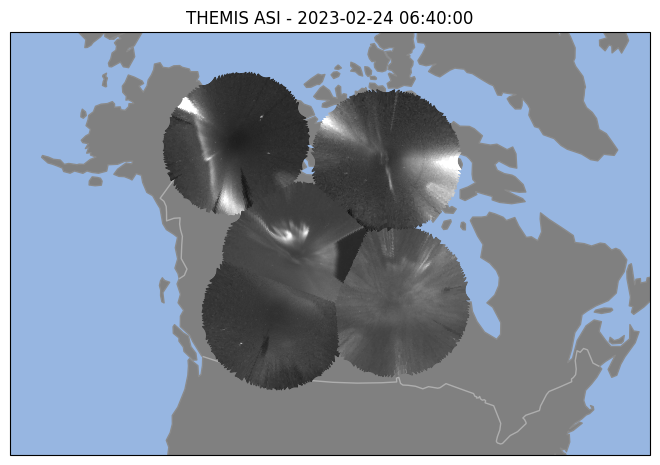

In [ ]:
# plot mosaic
map_extent = [-145, -65, 35, 80]
mosaic.plot(map_extent, title="THEMIS ASI - %s" % (image_data_list[0].timestamp[0].strftime("%Y-%m-%d %H:%M:%S")))

## **Mosaic of Luminosity in Rayleighs**

Using methods outlined in the 'loading calibrating and plotting single channel ASI data, we can convert image data to physical units (Rayleighs) and create a mosaic with more physical meaning.  


In [ ]:
# Let's load in some REGO data - we will also need the calibration files, as
# explained in the 'loading, calibrating, and plotting single channel asi data'
# crib sheet.
site_uid_list = ["fsim", "gill", "luck", "rank"]

# read raw data
image_file_list = [
    list(root_path.glob("REGO_RAW/2023/02/24/fsim*/ut06/20230224_0615*"))[0],
    list(root_path.glob("REGO_RAW/2023/02/24/gill*/ut06/20230224_0615*"))[0],
    list(root_path.glob("REGO_RAW/2023/02/24/luck*/ut06/20230224_0615*"))[0],
    list(root_path.glob("REGO_RAW/2023/02/24/rank*/ut06/20230224_0615*"))[0],
]
pprint.pprint(image_file_list)
print()
image_data_list = []
for f in image_file_list:
    image_data_list.append(aurorax.data.ucalgary.read(r_rego_raw_allsites1.dataset, f))
pprint.pprint(image_data_list)
print()

# read skymap data
skymap_file_list = [
    r_rego_skymaps["fsim"].filenames[0],
    r_rego_skymaps["gill"].filenames[0],
    r_rego_skymaps["luck"].filenames[0],
    r_rego_skymaps["rank"].filenames[0],
]
skymap_data = aurorax.data.ucalgary.read(r_rego_skymaps["fsim"].dataset, skymap_file_list)
print(skymap_data)
print()

# read flatfield calibration data
#
# NOTE: we order these to match the site order used for reading the raw and skymap data.
# We determined these numbers by the device UID found in the filenames of the raw data (alternatively
# found in the metadata for the raw files after read in).
cal_flatfield_file_list = [
    r_rego_cal_flatfields["656"].filenames[0],
    r_rego_cal_flatfields["652"].filenames[0],
    r_rego_cal_flatfields["651"].filenames[0],
    r_rego_cal_flatfields["649"].filenames[0],
]
cal_flatfield_data = aurorax.data.ucalgary.read(r_rego_cal_flatfields["656"].dataset, cal_flatfield_file_list)
print(cal_flatfield_data)
print()

# read rayleighs calibration data
cal_flatfield_file_list = [
    r_rego_cal_rayleighs["656"].filenames[0],
    r_rego_cal_rayleighs["652"].filenames[0],
    r_rego_cal_rayleighs["651"].filenames[0],
    r_rego_cal_rayleighs["649"].filenames[0],
]
cal_rayleighs_data = aurorax.data.ucalgary.read(r_rego_cal_rayleighs["656"].dataset, cal_flatfield_file_list)
print(cal_rayleighs_data)

[PosixPath('/content/ucalgary_data/REGO_RAW/2023/02/24/fsim_rego-656/ut06/20230224_0615_fsim_rego-656_6300.pgm.gz'),
 PosixPath('/content/ucalgary_data/REGO_RAW/2023/02/24/gill_rego-652/ut06/20230224_0615_gill_rego-652_6300.pgm.gz'),
 PosixPath('/content/ucalgary_data/REGO_RAW/2023/02/24/luck_rego-651/ut06/20230224_0615_luck_rego-651_6300.pgm.gz'),
 PosixPath('/content/ucalgary_data/REGO_RAW/2023/02/24/rank_rego-649/ut06/20230224_0615_rank_rego-649_6300.pgm.gz')]

[Data(data=array(dims=(512, 512, 20), dtype=uint16), timestamp=[20 datetimes], metadata=[20 dictionaries], problematic_files=[], calibrated_data=None, dataset=Dataset(name=REGO_RAW, short_description='REGO All Sky Imagers 3-sec raw da...)),
 Data(data=array(dims=(512, 512, 20), dtype=uint16), timestamp=[20 datetimes], metadata=[20 dictionaries], problematic_files=[], calibrated_data=None, dataset=Dataset(name=REGO_RAW, short_description='REGO All Sky Imagers 3-sec raw da...)),
 Data(data=array(dims=(512, 512, 20), dtype=uint1

In [ ]:
# apply calibration to images for each site
for i, image_data in enumerate(image_data_list):
    image_data_list[i].calibrated_data = at.calibration.rego(
        image_data.data,
        cal_flatfield=cal_flatfield_data.data[i],
        cal_rayleighs=cal_rayleighs_data.data[i],
    )
image_data_list

# you'll notice that the calibrated_data attribute is now populated with data

[Data(data=array(dims=(512, 512, 20), dtype=uint16), timestamp=[20 datetimes], metadata=[20 dictionaries], problematic_files=[], calibrated_data=array(dims=(512, 512, 20), dtype=float32), dataset=Dataset(name=REGO_RAW, short_description='REGO All Sky Imagers 3-sec raw da...)),
 Data(data=array(dims=(512, 512, 20), dtype=uint16), timestamp=[20 datetimes], metadata=[20 dictionaries], problematic_files=[], calibrated_data=array(dims=(512, 512, 20), dtype=float32), dataset=Dataset(name=REGO_RAW, short_description='REGO All Sky Imagers 3-sec raw da...)),
 Data(data=array(dims=(512, 512, 20), dtype=uint16), timestamp=[20 datetimes], metadata=[20 dictionaries], problematic_files=[], calibrated_data=array(dims=(512, 512, 20), dtype=float32), dataset=Dataset(name=REGO_RAW, short_description='REGO All Sky Imagers 3-sec raw da...)),
 Data(data=array(dims=(512, 512, 20), dtype=uint16), timestamp=[20 datetimes], metadata=[20 dictionaries], problematic_files=[], calibrated_data=array(dims=(512, 512,

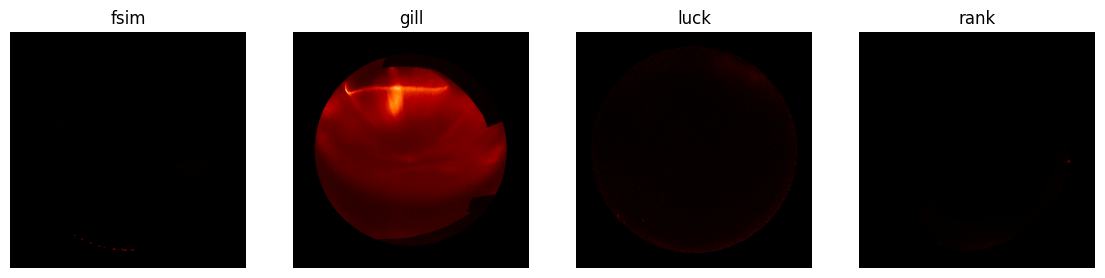

In [ ]:
# Let's plot each site, and label with the min and max of the data, so we can get a good idea of how we should scale.
plt.figure(figsize=(14, 4))
for i, image_data in enumerate(image_data_list):
    plt.subplot(1, len(site_uid_list), i + 1)
    plt.title(site_uid_list[i])
    plt.imshow(image_data.calibrated_data[:, :, 0], cmap="gist_heat", origin="lower")
    plt.axis("off")

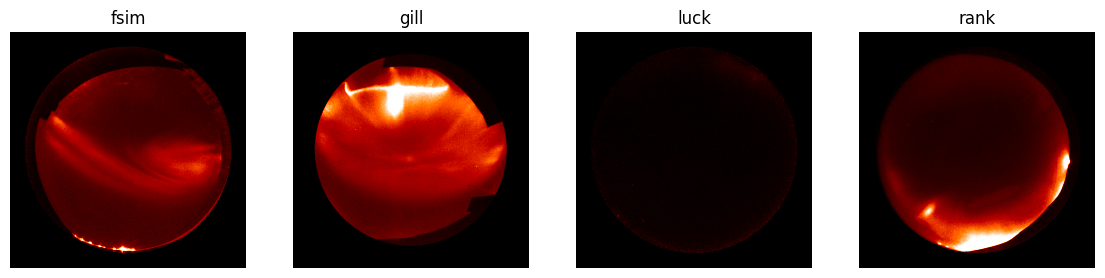

In [ ]:
# Since we are working with absolute intensity data, ALL SITES MUST BE SCALED THE SAME, let's mess around with the scaling
scale = [0, 5000]

# Let's plot each site, and label with the min and max of the data, so we can get a good idea of how we should scale.
plt.figure(figsize=(14, 4))
for i, image_data in enumerate(image_data_list):
    plt.subplot(1, len(site_uid_list), i + 1)
    plt.title(site_uid_list[i])
    cal_data = at.scale_intensity(image_data.calibrated_data, min=scale[0], max=scale[1], top=255)
    plt.imshow(cal_data[:, :, 0], cmap="gist_heat", origin="lower")
    plt.axis('off')

In [ ]:
# Prepare skymaps
prepped_skymap = at.mosaic.prep_skymaps(skymap_data.data, 230, n_parallel=2)
prepped_skymap

Preparing skymaps:   0%|          | 0/4 [00:00<?, ?skymap/s]

MosaicSkymap(polyfill_lat=array(dims=(5, 262144), dtype=float64), polyfill_lon=array(dims=(5, 262144), dtype=float64), elevation=array(dims=(262144,), dtype=float32), site_uid_list=['fsim', 'gill', 'luck', 'rank'])

In [ ]:
# prepare the image data
prepped_images = at.mosaic.prep_images(image_data_list, data_attribute="calibrated_data")
prepped_images

MosaicData(images=Dict[4 sites of array(dims=(512, 512))], timestamps=[20 timestamps], site_uid_list=['fsim', 'gill', 'luck', 'rank'])

In [ ]:
# create projection
center_lat = -100.0
center_lon = 55.0
projection_obj = cartopy.crs.NearsidePerspective(central_longitude=center_lat, central_latitude=center_lon)

# create mosaic
#
# NOTE: when we compute our flat field correction, we limit the FoV
# to 10 degree elevation angle, so calibrated mosaics will require
# a 10 degree elevation threshold. We use the 'min_elevation' parameter
# to set this (default is 5deg).
frame_num = 0
mosaic = at.mosaic.create(prepped_images,
                          prepped_skymap,
                          frame_num,
                          projection_obj,
                          image_intensity_scales=scale,
                          colormap="gist_heat",
                          min_elevation=10)
print(mosaic)

Mosaic(polygon_data=PolyCollection(...), cartopy_projection=Projection(+proj=nsper +a=6378137.0 +lon_0=-100.0 +lat_0=55.0 +h=35785831 +x_0=0 +y_0=0 +units=m +no_defs +type=crs))


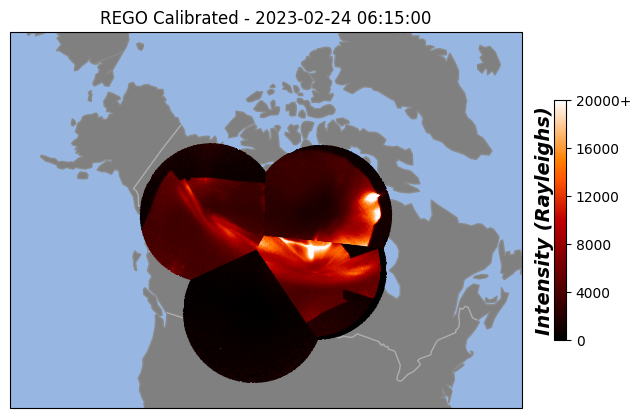

In [ ]:
# plot mosaic
map_extent = [-145, -65, 33, 85]
mosaic.plot(map_extent, rayleighs=True, cbar_colormap="gist_heat", title="REGO Calibrated - %s" % (image_data_list[0].timestamp[0].strftime("%Y-%m-%d %H:%M:%S")))